## Import Libraries

In [1]:
#import necessary libraries

import os
import cv2
import random
import itertools
from tqdm import tqdm
from pathlib import Path
from os import makedirs, listdir
from os.path import join, exists, isdir
from PIL import Image, ImageChops, ImageEnhance

import sklearn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, TensorBoard
from tensorflow.keras.applications import (MobileNetV2, Xception, InceptionV3, EfficientNetB7, ResNet101, NASNetLarge, 
                                           VGG19, VGG16, DenseNet201)
from tensorflow.keras.applications import (mobilenet_v2, xception, inception_v3, efficientnet, resnet, nasnet, vgg19, 
                                           vgg16, densenet)

np.random.seed(2)
plt.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = (8, 6)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Model Configuration

In [7]:
class Config:
    autotune = tf.data.experimental.AUTOTUNE
    epochs = 30
    batch_size = 64
    lr = 1e-3
    name = 'densenet'
    n_labels = 2
    image_size = (224, 224)
    decay = 1e-6
    momentum = 0.95
    nesterov = False

In [8]:
models = {
    'densenet': DenseNet201,
    'xception': Xception,
    'inceptionv3': InceptionV3,
    'effecientnetb7': EfficientNetB7,
    'vgg19': VGG19,
    'vgg16': VGG16,
    'nasnetlarge': NASNetLarge,
    'mobilenetv2': MobileNetV2,
    'resnet': ResNet101
}
# To use => myNet = models['densenet']() 

preprocess = {
    'densenet': densenet.preprocess_input,
    'xception': xception.preprocess_input,
    'inceptionv3': inception_v3.preprocess_input,
    'effecientnetb7': efficientnet.preprocess_input,
    'vgg19': vgg19.preprocess_input,
    'vgg16': vgg16.preprocess_input,
    'nasnetlarge': nasnet.preprocess_input,
    'mobilenetv2': mobilenet_v2.preprocess_input,
    'resnet': resnet.preprocess_input
}

## Functions of Image Preprocessing

In [53]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

In [54]:
image_size = (128,128)

In [55]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

## Dataset Preparation

In [56]:
X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real

In [73]:
path =r"C:\Users\HP\Documents\CASIA\CASIA2\Au"
for filename in os.listdir(path):
        full_path = os.path.join(path, filename)
        if filename=="Thumbs.db":
            continue
        X.append(prepare_image(full_path))
        Y.append(1)
        if len(Y) % 500 == 0:
            print(f'Processing {len(Y)} images')

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images


In [58]:
path =r"C:\Users\HP\Documents\CASIA\CASIA2\Tp"
for filename in os.listdir(path):
        full_path = os.path.join(path, filename)
        X.append(prepare_image(full_path))
        Y.append(0)
        if len(Y) % 500 == 0:
            print(f'Processing {len(Y)} images')

In [75]:
X = np.array(X)
X = X.reshape(-1,128,128, 3)

In [76]:
Y

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


## Partitioning dataset for training, validation and testing

In [77]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

10091 10091
2523 2523


In [78]:
X_train = np.array(X_train)
X_val = np.array(X_val)
Y_train = np.array(Y_train)
Y_val = np.array(Y_val)

## Utility functions for Training and Evaluations

In [5]:
from tensorflow.keras.layers import Dropout
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def create_model(optimizer, name='mobilenet', loss='categorical_crossentropy'):
    """
    Creates model based on the input name and freezes `blocks_to_train` blocks.
    Args: 
        optimizer(tf.keras.optimizers): initialized tensorflow optimizers.
        name(str): one of the keys in the `models` list.
        blocks_to_train: name of the blocks to freeze, if not given all the 
        layers will be trainable.
        loss: sets loss
        
    """
    
    base_model = models[name](include_top=False, weights='imagenet', input_shape=(128,128, 3))
    # model = Model(base_model.inputs, base_model.layers[-1].output)

    x = Flatten()(base_model.output)
#     x = Dense(1024, activation='relu')(x)
#     output = Dense(1, activation='sigmoid')(x)
    
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(base_model.inputs, output)
    
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=METRICS)
    return model

# def scheduler(epoch):
#     if epoch % 25 == 0 and epoch != 0:
#         lr = K.get_value(model.optimizer.lr)
#         K.set_value(model.optimizer.lr, lr * 0.9)
        
#     return K.get_value(model.optimizer.lr)

## Initializing the model

In [9]:
loss=tf.keras.losses.BinaryCrossentropy()
optimizer = Adam(learning_rate=Config.lr)
"""
Model             Params
mobilenet           3M 
effecientnetb7      66M 
nasnetlarge         89M
inceptionv3         23M
xception            22M
resnet              44M
densenet            20M

"""


model = create_model(optimizer, name=Config.name, loss=loss)

# model.summary()

74836368/74836368 [==============================] - 21s 0us/step


In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1/conv[0][0]']         

                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_2_conv (Conv2D)   (None, 32, 32, 32)   36864       ['conv2_block4_1_relu[0][0]']    
                                                                                                  
 conv2_block4_concat (Concatena  (None, 32, 32, 192)  0          ['conv2_block3_concat[0][0]',    
 te)      

 conv3_block2_1_conv (Conv2D)   (None, 16, 16, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 16, 16, 32)   36864       ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_blo

                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 16, 16, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 16, 16, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 16, 16, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block7_0_relu (Activatio  (None, 16, 16, 320)  0          ['conv3_block7_0_bn[0][0]']      
 n)       

 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 16, 16, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 16, 16, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_block11_1_bn (BatchNorma  (None, 16, 16, 128)  512        ['conv3_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_blo

 conv4_block3_0_bn (BatchNormal  (None, 8, 8, 320)   1280        ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 8, 8, 320)   0           ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 8, 8, 128)    40960       ['conv4_block3_0_relu[0][0]']    
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv4_block3_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 8, 8, 128)   0           ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 8, 8, 32)     36864       ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_block7_concat (Concatena  (None, 8, 8, 480)   0           ['conv4_block6_concat[0][0]',    
 te)      

 conv4_block11_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 8, 8, 608)   0           ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 8, 8, 608)   2432        ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block12_0_relu (Activati  (None, 8, 8, 608)   0           ['conv4_block12_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block16_0_relu (Activati  (None, 8, 8, 736)   0           ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 8, 8, 128)    94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block16_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block16_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_block20_concat (Concaten  (None, 8, 8, 896)   0           ['conv4_block19_concat[0][0]',   
 ate)                                                             'conv4_block20_2_conv[0][0]']   
                                                                                                  
 conv4_blo

 conv4_block24_concat (Concaten  (None, 8, 8, 1024)  0           ['conv4_block23_concat[0][0]',   
 ate)                                                             'conv4_block24_2_conv[0][0]']   
                                                                                                  
 conv4_block25_0_bn (BatchNorma  (None, 8, 8, 1024)  4096        ['conv4_block24_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block25_0_relu (Activati  (None, 8, 8, 1024)  0           ['conv4_block25_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block25_1_conv (Conv2D)  (None, 8, 8, 128)    131072      ['conv4_block25_0_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv4_block29_1_conv (Conv2D)  (None, 8, 8, 128)    147456      ['conv4_block29_0_relu[0][0]']   
                                                                                                  
 conv4_block29_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block29_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block29_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block29_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block33_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block33_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block33_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block33_1_relu[0][0]']   
                                                                                                  
 conv4_block33_concat (Concaten  (None, 8, 8, 1312)  0           ['conv4_block32_concat[0][0]',   
 ate)                                                             'conv4_block33_2_conv[0][0]']   
                                                                                                  
 conv4_block34_0_bn (BatchNorma  (None, 8, 8, 1312)  5248        ['conv4_block33_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block38_0_bn (BatchNorma  (None, 8, 8, 1440)  5760        ['conv4_block37_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block38_0_relu (Activati  (None, 8, 8, 1440)  0           ['conv4_block38_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block38_1_conv (Conv2D)  (None, 8, 8, 128)    184320      ['conv4_block38_0_relu[0][0]']   
                                                                                                  
 conv4_block38_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block38_1_conv[0][0]']   
 lization)

 conv4_block42_1_conv (Conv2D)  (None, 8, 8, 128)    200704      ['conv4_block42_0_relu[0][0]']   
                                                                                                  
 conv4_block42_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv4_block42_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block42_1_relu (Activati  (None, 8, 8, 128)   0           ['conv4_block42_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block42_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block42_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block46_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv4_block46_1_relu[0][0]']   
                                                                                                  
 conv4_block46_concat (Concaten  (None, 8, 8, 1728)  0           ['conv4_block45_concat[0][0]',   
 ate)                                                             'conv4_block46_2_conv[0][0]']   
                                                                                                  
 conv4_block47_0_bn (BatchNorma  (None, 8, 8, 1728)  6912        ['conv4_block46_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block47_0_relu (Activati  (None, 8, 8, 1728)  0           ['conv4_block47_0_bn[0][0]']     
 on)      

 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 4, 4, 32)     36864       ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_block2_concat (Concatena  (None, 4, 4, 960)   0           ['conv5_block1_concat[0][0]',    
 te)                                                              'conv5_block2_2_conv[0][0]']    
                                                                                                  
 conv5_block3_0_bn (BatchNormal  (None, 4, 4, 960)   3840        ['conv5_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_blo

 conv5_block7_0_bn (BatchNormal  (None, 4, 4, 1088)  4352        ['conv5_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block7_0_relu (Activatio  (None, 4, 4, 1088)  0           ['conv5_block7_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block7_1_conv (Conv2D)   (None, 4, 4, 128)    139264      ['conv5_block7_0_relu[0][0]']    
                                                                                                  
 conv5_block7_1_bn (BatchNormal  (None, 4, 4, 128)   512         ['conv5_block7_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv5_block11_1_bn (BatchNorma  (None, 4, 4, 128)   512         ['conv5_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block11_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block11_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block11_1_relu[0][0]']   
                                                                                                  
 conv5_block11_concat (Concaten  (None, 4, 4, 1248)  0           ['conv5_block10_concat[0][0]',   
 ate)     

 conv5_block15_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block15_1_relu[0][0]']   
                                                                                                  
 conv5_block15_concat (Concaten  (None, 4, 4, 1376)  0           ['conv5_block14_concat[0][0]',   
 ate)                                                             'conv5_block15_2_conv[0][0]']   
                                                                                                  
 conv5_block16_0_bn (BatchNorma  (None, 4, 4, 1376)  5504        ['conv5_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block16_0_relu (Activati  (None, 4, 4, 1376)  0           ['conv5_block16_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv5_block20_0_relu (Activati  (None, 4, 4, 1504)  0           ['conv5_block20_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block20_1_conv (Conv2D)  (None, 4, 4, 128)    192512      ['conv5_block20_0_relu[0][0]']   
                                                                                                  
 conv5_block20_1_bn (BatchNorma  (None, 4, 4, 128)   512         ['conv5_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block20_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block20_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv5_block24_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block24_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block24_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block24_1_relu[0][0]']   
                                                                                                  
 conv5_block24_concat (Concaten  (None, 4, 4, 1664)  0           ['conv5_block23_concat[0][0]',   
 ate)                                                             'conv5_block24_2_conv[0][0]']   
                                                                                                  
 conv5_blo

 conv5_block28_concat (Concaten  (None, 4, 4, 1792)  0           ['conv5_block27_concat[0][0]',   
 ate)                                                             'conv5_block28_2_conv[0][0]']   
                                                                                                  
 conv5_block29_0_bn (BatchNorma  (None, 4, 4, 1792)  7168        ['conv5_block28_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block29_0_relu (Activati  (None, 4, 4, 1792)  0           ['conv5_block29_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block29_1_conv (Conv2D)  (None, 4, 4, 128)    229376      ['conv5_block29_0_relu[0][0]']   
          

 flatten (Flatten)              (None, 30720)        0           ['relu[0][0]']                   
                                                                                                  
 dense (Dense)                  (None, 256)          7864576     ['flatten[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 256)          0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 1)            257         ['dropout[0][0]']                
                                                                                                  
Total params: 26,186,817
Trainable params: 25,957,761
Non-trainable params: 229,056
__________________________________________________________________________________________________


In [79]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = Config.batch_size,
                 epochs = 6,
                validation_data = (X_val, Y_val))

Epoch 1/6
158/158 [==============================] - 1487s 9s/step - loss: 0.6618 - accuracy: 1.0000 - precision: 0.5881 - recall: 0.9358 - auc: 0.5262 - prc: 0.6606 - val_loss: 0.7225 - val_accuracy: 1.0000 - val_precision: 0.6175 - val_recall: 1.0000 - val_auc: 0.6395 - val_prc: 0.7760
Epoch 2/6
158/158 [==============================] - 1260s 8s/step - loss: 0.2867 - accuracy: 1.0000 - precision: 0.9431 - recall: 0.8461 - auc: 0.9426 - prc: 0.9641 - val_loss: 0.6399 - val_accuracy: 1.0000 - val_precision: 0.6363 - val_recall: 0.9872 - val_auc: 0.6074 - val_prc: 0.7422
Epoch 3/6
158/158 [==============================] - 1878s 12s/step - loss: 0.2060 - accuracy: 1.0000 - precision: 0.9479 - recall: 0.8899 - auc: 0.9717 - prc: 0.9816 - val_loss: 3.0798 - val_accuracy: 1.0000 - val_precision: 0.7445 - val_recall: 0.9294 - val_auc: 0.7374 - val_prc: 0.7435
Epoch 4/6
158/158 [==============================] - 1242s 8s/step - loss: 0.1639 - accuracy: 1.0000 - precision: 0.9688 - recall: 0

# Evaluation

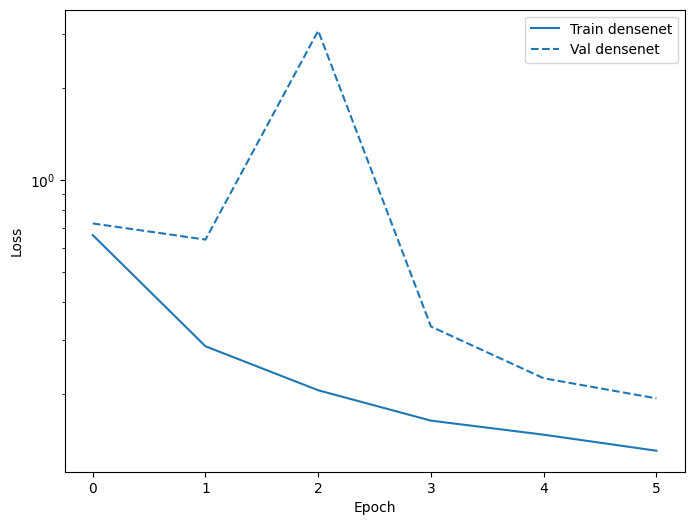

In [80]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#evaluate_metrics
# Plot loss

def plot_loss(history, label, n):
    # Use a log scale on y-axis to show the wide range of values.
    plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plot_loss(hist, Config.name, 0)

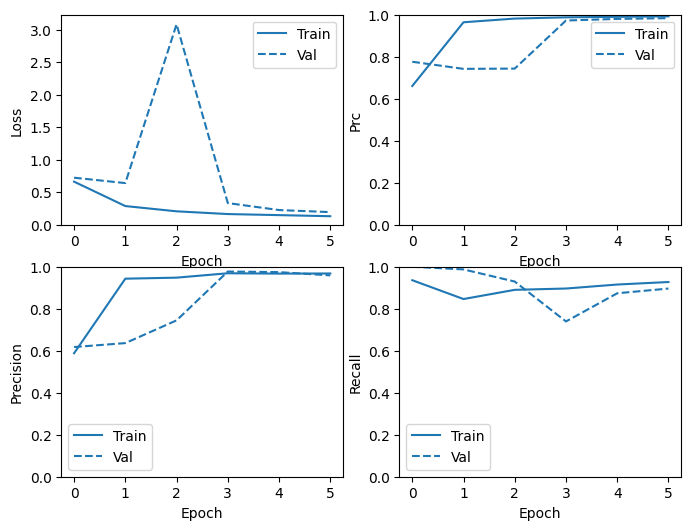

In [81]:
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],color=colors[0], 
                 linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

plot_metrics(hist)

## Saving the model

In [2]:
from tensorflow.keras.models import Sequential, model_from_json

In [94]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("densenet_model.h5")
print("Saved model to disk")

Saved model to disk


## Feature Extraction for individual images

In [3]:
json_file = open(r'C:\Users\HP\Documents\model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(r"C:\Users\HP\Documents\densenet_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [29]:
loaded_model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=METRICS)

In [10]:
for layer in loaded_model.layers:
    print(layer.name)

input_4
block1_conv1
block1_conv1_bn
block1_conv1_act
block1_conv2
block1_conv2_bn
block1_conv2_act
block2_sepconv1
block2_sepconv1_bn
block2_sepconv2_act
block2_sepconv2
block2_sepconv2_bn
conv2d_12
block2_pool
batch_normalization_12
add_36
block3_sepconv1_act
block3_sepconv1
block3_sepconv1_bn
block3_sepconv2_act
block3_sepconv2
block3_sepconv2_bn
conv2d_13
block3_pool
batch_normalization_13
add_37
block4_sepconv1_act
block4_sepconv1
block4_sepconv1_bn
block4_sepconv2_act
block4_sepconv2
block4_sepconv2_bn
conv2d_14
block4_pool
batch_normalization_14
add_38
block5_sepconv1_act
block5_sepconv1
block5_sepconv1_bn
block5_sepconv2_act
block5_sepconv2
block5_sepconv2_bn
block5_sepconv3_act
block5_sepconv3
block5_sepconv3_bn
add_39
block6_sepconv1_act
block6_sepconv1
block6_sepconv1_bn
block6_sepconv2_act
block6_sepconv2
block6_sepconv2_bn
block6_sepconv3_act
block6_sepconv3
block6_sepconv3_bn
add_40
block7_sepconv1_act
block7_sepconv1
block7_sepconv1_bn
block7_sepconv2_act
block7_sepconv2

In [4]:
transfer_layer= loaded_model.get_layer("dense_6")

print(transfer_layer.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='dense_6/Relu:0', description="created by layer 'dense_6'")


In [31]:
model = Model(inputs=loaded_model.input,outputs=transfer_layer.output)

In [32]:
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=METRICS)

In [33]:
path = r"C:\Users\HP\Documents\CASIA\CASIA2\Tp\Tp_D_CND_M_N_art00077_art00076_10290.tif"

X = prepare_image(path)

In [34]:
X = np.array(X)
X = X.reshape(-1,128,128, 3)

In [36]:
l = model.predict(X)
print(l[0])

1/1 [==============================] - 0s 107ms/step
[0.         2.96544    0.         0.         0.         1.6199976
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.554707   0.         1.2972004  0.         0.85093063
 0.         2.2516856  1.5977026  0.         0.         0.
 0.         0.8339951  0.         0.         2.3948312  0.
 0.         0.         0.         0.         0.         0.
 2.2496762  2.509519   0.         0.         0.         2.0231597
 0.         1.1650833  1.2906162  0.         0.         0.
 0.         2.5989993  0.         0.         0.         0.
 0.8293266  0.         0.         2.4387732  0.         0.
 0.         0.         0.         3.84061    0.         1.6603065
 0.         0.         0.         0.         0.         0.
 0.         1.6199614  0.        

In [37]:
dense_out = []

In [38]:
path =r"C:\Users\HP\Documents\CASIA\CASIA2\Au"
cnt = 0
for filename in os.listdir(path):
        full_path = os.path.join(path, filename)
        X = prepare_image(full_path)
        X = np.array(X)
        X = X.reshape(-1,128,128, 3)
        l = model.predict(X)
        dense_out.append(l[0])
        if cnt % 10 == 0:
            print(f'Processing {cnt} images')
        cnt += 1

1/1 [==============================] - 0s 127ms/step
Processing 0 images
1/1 [==============================] - 0s 113ms/step
Processing 10 images
1/1 [==============================] - 0s 91ms/step
Processing 20 images
1/1 [==============================] - 0s 100ms/step
Processing 30 images
1/1 [==============================] - 0s 110ms/step
Processing 40 images
1/1 [==============================] - 0s 89ms/step
Processing 50 images
1/1 [==============================] - 0s 104ms/step
Processing 60 images
1/1 [==============================] - 0s 95ms/step
Processing 70 images
1/1 [==============================] - 0s 81ms/step
Processing 80 images
1/1 [==============================] - 0s 96ms/step
Processing 90 images
1/1 [==============================] - 0s 82ms/step
Processing 100 images
1/1 [==============================] - 0s 85ms/step
Processing 110 images
1/1 [==============================] - 0s 85ms/step
Processing 120 images
1/1 [==============================] - 0s 86

1/1 [==============================] - 0s 80ms/step
Processing 310 images
1/1 [==============================] - 0s 79ms/step
Processing 320 images
1/1 [==============================] - 0s 85ms/step
Processing 330 images
1/1 [==============================] - 0s 97ms/step
Processing 340 images
1/1 [==============================] - 0s 97ms/step
Processing 350 images
1/1 [==============================] - 0s 97ms/step
Processing 360 images
1/1 [==============================] - 0s 95ms/step
Processing 370 images
1/1 [==============================] - 0s 97ms/step
Processing 380 images
1/1 [==============================] - 0s 101ms/step
Processing 390 images
1/1 [==============================] - 0s 87ms/step
Processing 400 images
1/1 [==============================] - 0s 83ms/step
Processing 410 images
1/1 [==============================] - 0s 96ms/step
Processing 420 images
1/1 [==============================] - 0s 87ms/step
Processing 430 images
1/1 [==============================] 

1/1 [==============================] - 0s 97ms/step
Processing 610 images
1/1 [==============================] - 0s 102ms/step
Processing 620 images
1/1 [==============================] - 0s 107ms/step
Processing 630 images
1/1 [==============================] - 0s 94ms/step
Processing 640 images
1/1 [==============================] - 0s 87ms/step
Processing 650 images
1/1 [==============================] - 0s 95ms/step
Processing 660 images
1/1 [==============================] - 0s 90ms/step
Processing 670 images
1/1 [==============================] - 0s 92ms/step
Processing 680 images
1/1 [==============================] - 0s 82ms/step
Processing 690 images
1/1 [==============================] - 0s 82ms/step
Processing 700 images
1/1 [==============================] - 0s 83ms/step
Processing 710 images
1/1 [==============================] - 0s 79ms/step
Processing 720 images
1/1 [==============================] - 0s 79ms/step
Processing 730 images
1/1 [==============================]

1/1 [==============================] - 0s 80ms/step
Processing 910 images
1/1 [==============================] - 0s 95ms/step
Processing 920 images
1/1 [==============================] - 0s 96ms/step
Processing 930 images
1/1 [==============================] - 0s 95ms/step
Processing 940 images
1/1 [==============================] - 0s 88ms/step
Processing 950 images
1/1 [==============================] - 0s 95ms/step
Processing 960 images
1/1 [==============================] - 0s 96ms/step
Processing 970 images
1/1 [==============================] - 0s 80ms/step
Processing 980 images
1/1 [==============================] - 0s 81ms/step
Processing 990 images
1/1 [==============================] - 0s 78ms/step
Processing 1000 images
1/1 [==============================] - 0s 81ms/step
Processing 1010 images
1/1 [==============================] - 0s 83ms/step
Processing 1020 images
1/1 [==============================] - 0s 78ms/step
Processing 1030 images
1/1 [=============================

1/1 [==============================] - 0s 79ms/step
Processing 1060 images
1/1 [==============================] - 0s 87ms/step
Processing 1070 images
1/1 [==============================] - 0s 91ms/step
Processing 1080 images
1/1 [==============================] - 0s 95ms/step
Processing 1090 images
1/1 [==============================] - 0s 84ms/step
Processing 1100 images
1/1 [==============================] - 0s 102ms/step
Processing 1110 images
1/1 [==============================] - 0s 95ms/step
Processing 1120 images
1/1 [==============================] - 0s 85ms/step
Processing 1130 images
1/1 [==============================] - 0s 94ms/step
Processing 1140 images
1/1 [==============================] - 0s 86ms/step
Processing 1150 images
1/1 [==============================] - 0s 80ms/step
Processing 1160 images
1/1 [==============================] - 0s 87ms/step
Processing 1170 images
1/1 [==============================] - 0s 83ms/step
Processing 1180 images
1/1 [===================

1/1 [==============================] - 0s 92ms/step
Processing 1360 images
1/1 [==============================] - 0s 83ms/step
Processing 1370 images
1/1 [==============================] - 0s 80ms/step
Processing 1380 images
1/1 [==============================] - 0s 93ms/step
Processing 1390 images
1/1 [==============================] - 0s 78ms/step
Processing 1400 images
1/1 [==============================] - 0s 78ms/step
Processing 1410 images
1/1 [==============================] - 0s 78ms/step
Processing 1420 images
1/1 [==============================] - 0s 84ms/step
Processing 1430 images
1/1 [==============================] - 0s 80ms/step
Processing 1440 images
1/1 [==============================] - 0s 95ms/step
Processing 1450 images
1/1 [==============================] - 0s 93ms/step
Processing 1460 images
1/1 [==============================] - 0s 80ms/step
Processing 1470 images
1/1 [==============================] - 0s 80ms/step
Processing 1480 images
1/1 [====================

1/1 [==============================] - 0s 78ms/step
Processing 1510 images
1/1 [==============================] - 0s 80ms/step
Processing 1520 images
1/1 [==============================] - 0s 88ms/step
Processing 1530 images
1/1 [==============================] - 0s 111ms/step
Processing 1540 images
1/1 [==============================] - 0s 95ms/step
Processing 1550 images
1/1 [==============================] - 0s 98ms/step
Processing 1560 images
1/1 [==============================] - 0s 87ms/step
Processing 1570 images
1/1 [==============================] - 0s 95ms/step
Processing 1580 images
1/1 [==============================] - 0s 95ms/step
Processing 1590 images
1/1 [==============================] - 0s 93ms/step
Processing 1600 images
1/1 [==============================] - 0s 92ms/step
Processing 1610 images
1/1 [==============================] - 0s 78ms/step
Processing 1620 images
1/1 [==============================] - 0s 92ms/step
Processing 1630 images
1/1 [===================

1/1 [==============================] - 0s 88ms/step
Processing 1810 images
1/1 [==============================] - 0s 90ms/step
Processing 1820 images
1/1 [==============================] - 0s 108ms/step
Processing 1830 images
1/1 [==============================] - 0s 92ms/step
Processing 1840 images
1/1 [==============================] - 0s 85ms/step
Processing 1850 images
1/1 [==============================] - 0s 80ms/step
Processing 1860 images
1/1 [==============================] - 0s 87ms/step
Processing 1870 images
1/1 [==============================] - 0s 79ms/step
Processing 1880 images
1/1 [==============================] - 0s 79ms/step
Processing 1890 images
1/1 [==============================] - 0s 98ms/step
Processing 1900 images
1/1 [==============================] - 0s 93ms/step
Processing 1910 images
1/1 [==============================] - 0s 94ms/step
Processing 1920 images
1/1 [==============================] - 0s 79ms/step
Processing 1930 images
1/1 [===================

1/1 [==============================] - 0s 79ms/step
Processing 2110 images
1/1 [==============================] - 0s 83ms/step
Processing 2120 images
1/1 [==============================] - 0s 95ms/step
Processing 2130 images
1/1 [==============================] - 0s 107ms/step
Processing 2140 images
1/1 [==============================] - 0s 96ms/step
Processing 2150 images
1/1 [==============================] - 0s 85ms/step
Processing 2160 images
1/1 [==============================] - 0s 88ms/step
Processing 2170 images
1/1 [==============================] - 0s 78ms/step
Processing 2180 images
1/1 [==============================] - 0s 96ms/step
Processing 2190 images
1/1 [==============================] - 0s 79ms/step
Processing 2200 images
1/1 [==============================] - 0s 79ms/step
Processing 2210 images
1/1 [==============================] - 0s 71ms/step
Processing 2220 images
1/1 [==============================] - 0s 84ms/step
Processing 2230 images
1/1 [===================

1/1 [==============================] - 0s 75ms/step
Processing 2410 images
1/1 [==============================] - 0s 78ms/step
Processing 2420 images
1/1 [==============================] - 0s 80ms/step
Processing 2430 images
1/1 [==============================] - 0s 84ms/step
Processing 2440 images
1/1 [==============================] - 0s 94ms/step
Processing 2450 images
1/1 [==============================] - 0s 96ms/step
Processing 2460 images
1/1 [==============================] - 0s 80ms/step
Processing 2470 images
1/1 [==============================] - 0s 71ms/step
Processing 2480 images
1/1 [==============================] - 0s 71ms/step
Processing 2490 images
1/1 [==============================] - 0s 79ms/step
Processing 2500 images
1/1 [==============================] - 0s 71ms/step
Processing 2510 images
1/1 [==============================] - 0s 94ms/step
Processing 2520 images
1/1 [==============================] - 0s 81ms/step
Processing 2530 images
1/1 [====================

1/1 [==============================] - 0s 85ms/step
Processing 2710 images
1/1 [==============================] - 0s 94ms/step
Processing 2720 images
1/1 [==============================] - 0s 88ms/step
Processing 2730 images
1/1 [==============================] - 0s 81ms/step
Processing 2740 images
1/1 [==============================] - 0s 95ms/step
Processing 2750 images
1/1 [==============================] - 0s 95ms/step
Processing 2760 images
1/1 [==============================] - 0s 87ms/step
Processing 2770 images
1/1 [==============================] - 0s 80ms/step
Processing 2780 images
1/1 [==============================] - 0s 82ms/step
Processing 2790 images
1/1 [==============================] - 0s 83ms/step
Processing 2800 images
1/1 [==============================] - 0s 88ms/step
Processing 2810 images
1/1 [==============================] - 0s 82ms/step
Processing 2820 images
1/1 [==============================] - 0s 83ms/step
Processing 2830 images
1/1 [====================

1/1 [==============================] - 0s 80ms/step
Processing 3010 images
1/1 [==============================] - 0s 80ms/step
Processing 3020 images
1/1 [==============================] - 0s 88ms/step
Processing 3030 images
1/1 [==============================] - 0s 81ms/step
Processing 3040 images
1/1 [==============================] - 0s 93ms/step
Processing 3050 images
1/1 [==============================] - 0s 100ms/step
Processing 3060 images
1/1 [==============================] - 0s 94ms/step
Processing 3070 images
1/1 [==============================] - 0s 95ms/step
Processing 3080 images
1/1 [==============================] - 0s 94ms/step
Processing 3090 images
1/1 [==============================] - 0s 71ms/step
Processing 3100 images
1/1 [==============================] - 0s 79ms/step
Processing 3110 images
1/1 [==============================] - 0s 79ms/step
Processing 3120 images
1/1 [==============================] - 0s 87ms/step
Processing 3130 images
1/1 [===================

1/1 [==============================] - 0s 97ms/step
Processing 3310 images
1/1 [==============================] - 0s 95ms/step
Processing 3320 images
1/1 [==============================] - 0s 94ms/step
Processing 3330 images
1/1 [==============================] - 0s 91ms/step
Processing 3340 images
1/1 [==============================] - 0s 87ms/step
Processing 3350 images
1/1 [==============================] - 0s 96ms/step
Processing 3360 images
1/1 [==============================] - 0s 90ms/step
Processing 3370 images
1/1 [==============================] - 0s 85ms/step
Processing 3380 images
1/1 [==============================] - 0s 94ms/step
Processing 3390 images
1/1 [==============================] - 0s 95ms/step
Processing 3400 images
1/1 [==============================] - 0s 85ms/step
Processing 3410 images
1/1 [==============================] - 0s 205ms/step
Processing 3420 images
1/1 [==============================] - 0s 90ms/step
Processing 3430 images
1/1 [===================

1/1 [==============================] - 0s 87ms/step
Processing 3610 images
1/1 [==============================] - 0s 89ms/step
Processing 3620 images
1/1 [==============================] - 0s 89ms/step
Processing 3630 images
1/1 [==============================] - 0s 86ms/step
Processing 3640 images
1/1 [==============================] - 0s 86ms/step
Processing 3650 images
1/1 [==============================] - 0s 85ms/step
Processing 3660 images
1/1 [==============================] - 0s 90ms/step
Processing 3670 images
1/1 [==============================] - 0s 90ms/step
Processing 3680 images
1/1 [==============================] - 0s 88ms/step
Processing 3690 images
1/1 [==============================] - 0s 81ms/step
Processing 3700 images
1/1 [==============================] - 0s 84ms/step
Processing 3710 images
1/1 [==============================] - 0s 88ms/step
Processing 3720 images
1/1 [==============================] - 0s 80ms/step
Processing 3730 images
1/1 [====================

1/1 [==============================] - 0s 90ms/step
Processing 3760 images
1/1 [==============================] - 0s 85ms/step
Processing 3770 images
1/1 [==============================] - 0s 85ms/step
Processing 3780 images
1/1 [==============================] - 0s 87ms/step
Processing 3790 images
1/1 [==============================] - 0s 88ms/step
Processing 3800 images
1/1 [==============================] - 0s 85ms/step
Processing 3810 images
1/1 [==============================] - 0s 86ms/step
Processing 3820 images
1/1 [==============================] - 0s 82ms/step
Processing 3830 images
1/1 [==============================] - 0s 88ms/step
Processing 3840 images
1/1 [==============================] - 0s 88ms/step
Processing 3850 images
1/1 [==============================] - 0s 86ms/step
Processing 3860 images
1/1 [==============================] - 0s 84ms/step
Processing 3870 images
1/1 [==============================] - 0s 88ms/step
Processing 3880 images
1/1 [====================

1/1 [==============================] - 0s 86ms/step
Processing 3910 images
1/1 [==============================] - 0s 91ms/step
Processing 3920 images
1/1 [==============================] - 0s 89ms/step
Processing 3930 images
1/1 [==============================] - 0s 92ms/step
Processing 3940 images
1/1 [==============================] - 0s 87ms/step
Processing 3950 images
1/1 [==============================] - 0s 85ms/step
Processing 3960 images
1/1 [==============================] - 0s 93ms/step
Processing 3970 images
1/1 [==============================] - 0s 92ms/step
Processing 3980 images
1/1 [==============================] - 0s 87ms/step
Processing 3990 images
1/1 [==============================] - 0s 87ms/step
Processing 4000 images
1/1 [==============================] - 0s 83ms/step
Processing 4010 images
1/1 [==============================] - 0s 89ms/step
Processing 4020 images
1/1 [==============================] - 0s 95ms/step
Processing 4030 images
1/1 [====================

1/1 [==============================] - 0s 92ms/step
Processing 4210 images
1/1 [==============================] - 0s 109ms/step
Processing 4220 images
1/1 [==============================] - 0s 96ms/step
Processing 4230 images
1/1 [==============================] - 0s 126ms/step
Processing 4240 images
1/1 [==============================] - 0s 98ms/step
Processing 4250 images
1/1 [==============================] - 0s 114ms/step
Processing 4260 images
1/1 [==============================] - 0s 90ms/step
Processing 4270 images
1/1 [==============================] - 0s 104ms/step
Processing 4280 images
1/1 [==============================] - 0s 113ms/step
Processing 4290 images
1/1 [==============================] - 0s 90ms/step
Processing 4300 images
1/1 [==============================] - 0s 97ms/step
Processing 4310 images
1/1 [==============================] - 0s 97ms/step
Processing 4320 images
1/1 [==============================] - 0s 92ms/step
Processing 4330 images
1/1 [===============

1/1 [==============================] - 0s 107ms/step
Processing 4510 images
1/1 [==============================] - 0s 96ms/step
Processing 4520 images
1/1 [==============================] - 0s 135ms/step
Processing 4530 images
1/1 [==============================] - 0s 97ms/step
Processing 4540 images
1/1 [==============================] - 0s 93ms/step
Processing 4550 images
1/1 [==============================] - 0s 106ms/step
Processing 4560 images
1/1 [==============================] - 0s 97ms/step
Processing 4570 images
1/1 [==============================] - 0s 106ms/step
Processing 4580 images
1/1 [==============================] - 0s 90ms/step
Processing 4590 images
1/1 [==============================] - 0s 97ms/step
Processing 4600 images
1/1 [==============================] - 0s 105ms/step
Processing 4610 images
1/1 [==============================] - 0s 94ms/step
Processing 4620 images
1/1 [==============================] - 0s 167ms/step
Processing 4630 images
1/1 [==============

1/1 [==============================] - 0s 190ms/step
Processing 4810 images
1/1 [==============================] - 0s 90ms/step
Processing 4820 images
1/1 [==============================] - 0s 88ms/step
Processing 4830 images
1/1 [==============================] - 0s 120ms/step
Processing 4840 images
1/1 [==============================] - 0s 105ms/step
Processing 4850 images
1/1 [==============================] - 0s 107ms/step
Processing 4860 images
1/1 [==============================] - 0s 107ms/step
Processing 4870 images
1/1 [==============================] - 0s 119ms/step
Processing 4880 images
1/1 [==============================] - 0s 115ms/step
Processing 4890 images
1/1 [==============================] - 0s 121ms/step
Processing 4900 images
1/1 [==============================] - 0s 108ms/step
Processing 4910 images
1/1 [==============================] - 0s 111ms/step
Processing 4920 images
1/1 [==============================] - 0s 93ms/step
Processing 4930 images
1/1 [==========

1/1 [==============================] - 0s 96ms/step
Processing 5110 images
1/1 [==============================] - 0s 97ms/step
Processing 5120 images
1/1 [==============================] - 0s 119ms/step
Processing 5130 images
1/1 [==============================] - 0s 123ms/step
Processing 5140 images
1/1 [==============================] - 0s 97ms/step
Processing 5150 images
1/1 [==============================] - 0s 105ms/step
Processing 5160 images
1/1 [==============================] - 0s 110ms/step
Processing 5170 images
1/1 [==============================] - 0s 109ms/step
Processing 5180 images
1/1 [==============================] - 0s 96ms/step
Processing 5190 images
1/1 [==============================] - 0s 97ms/step
Processing 5200 images
1/1 [==============================] - 0s 96ms/step
Processing 5210 images
1/1 [==============================] - 0s 116ms/step
Processing 5220 images
1/1 [==============================] - 0s 115ms/step
Processing 5230 images
1/1 [=============

1/1 [==============================] - 0s 110ms/step
Processing 5400 images
1/1 [==============================] - 0s 117ms/step
Processing 5410 images
1/1 [==============================] - 0s 121ms/step
Processing 5420 images
1/1 [==============================] - 0s 132ms/step
Processing 5430 images
1/1 [==============================] - 0s 113ms/step
Processing 5440 images
1/1 [==============================] - 0s 115ms/step
Processing 5450 images
1/1 [==============================] - 0s 127ms/step
Processing 5460 images
1/1 [==============================] - 0s 116ms/step
Processing 5470 images
1/1 [==============================] - 0s 108ms/step
Processing 5480 images
1/1 [==============================] - 0s 108ms/step
Processing 5490 images
1/1 [==============================] - 0s 100ms/step
Processing 5500 images
1/1 [==============================] - 0s 104ms/step
Processing 5510 images
1/1 [==============================] - 0s 102ms/step
Processing 5520 images
1/1 [=======

1/1 [==============================] - 0s 103ms/step
Processing 5700 images
1/1 [==============================] - 0s 98ms/step
Processing 5710 images
1/1 [==============================] - 0s 113ms/step
Processing 5720 images
1/1 [==============================] - 0s 129ms/step
Processing 5730 images
1/1 [==============================] - 0s 136ms/step
Processing 5740 images
1/1 [==============================] - 0s 119ms/step
Processing 5750 images
1/1 [==============================] - 0s 123ms/step
Processing 5760 images
1/1 [==============================] - 0s 98ms/step
Processing 5770 images
1/1 [==============================] - 0s 110ms/step
Processing 5780 images
1/1 [==============================] - 0s 106ms/step
Processing 5790 images
1/1 [==============================] - 0s 99ms/step
Processing 5800 images
1/1 [==============================] - 0s 112ms/step
Processing 5810 images
1/1 [==============================] - 0s 109ms/step
Processing 5820 images
1/1 [==========

1/1 [==============================] - 0s 110ms/step
Processing 6000 images
1/1 [==============================] - 0s 120ms/step
Processing 6010 images
1/1 [==============================] - 0s 110ms/step
Processing 6020 images
1/1 [==============================] - 0s 105ms/step
Processing 6030 images
1/1 [==============================] - 0s 205ms/step
Processing 6040 images
1/1 [==============================] - 0s 124ms/step
Processing 6050 images
1/1 [==============================] - 0s 107ms/step
Processing 6060 images
1/1 [==============================] - 0s 105ms/step
Processing 6070 images
1/1 [==============================] - 0s 112ms/step
Processing 6080 images
1/1 [==============================] - 0s 110ms/step
Processing 6090 images
1/1 [==============================] - 0s 123ms/step
Processing 6100 images
1/1 [==============================] - 0s 108ms/step
Processing 6110 images
1/1 [==============================] - 0s 130ms/step
Processing 6120 images
1/1 [=======

1/1 [==============================] - 0s 115ms/step
Processing 6290 images
1/1 [==============================] - 0s 103ms/step
Processing 6300 images
1/1 [==============================] - 0s 140ms/step
Processing 6310 images
1/1 [==============================] - 0s 156ms/step
Processing 6320 images
1/1 [==============================] - 0s 129ms/step
Processing 6330 images
1/1 [==============================] - 0s 143ms/step
Processing 6340 images
1/1 [==============================] - 0s 129ms/step
Processing 6350 images
1/1 [==============================] - 0s 143ms/step
Processing 6360 images
1/1 [==============================] - 0s 128ms/step
Processing 6370 images
1/1 [==============================] - 0s 128ms/step
Processing 6380 images
1/1 [==============================] - 0s 128ms/step
Processing 6390 images
1/1 [==============================] - 0s 132ms/step
Processing 6400 images
1/1 [==============================] - 0s 129ms/step
Processing 6410 images
1/1 [=======

1/1 [==============================] - 0s 170ms/step
Processing 6590 images
1/1 [==============================] - 0s 173ms/step
Processing 6600 images
1/1 [==============================] - 0s 204ms/step
Processing 6610 images
1/1 [==============================] - 0s 164ms/step
Processing 6620 images
1/1 [==============================] - 0s 183ms/step
Processing 6630 images
1/1 [==============================] - 0s 184ms/step
Processing 6640 images
1/1 [==============================] - 0s 203ms/step
Processing 6650 images
1/1 [==============================] - 0s 174ms/step
Processing 6660 images
1/1 [==============================] - 0s 202ms/step
Processing 6670 images
1/1 [==============================] - 0s 168ms/step
Processing 6680 images
1/1 [==============================] - 0s 185ms/step
Processing 6690 images
1/1 [==============================] - 0s 193ms/step
Processing 6700 images
1/1 [==============================] - 0s 172ms/step
Processing 6710 images
1/1 [=======

1/1 [==============================] - 0s 187ms/step
Processing 6880 images
1/1 [==============================] - 0s 194ms/step
Processing 6890 images
1/1 [==============================] - 0s 194ms/step
Processing 6900 images
1/1 [==============================] - 0s 195ms/step
Processing 6910 images
1/1 [==============================] - 0s 197ms/step
Processing 6920 images
1/1 [==============================] - 0s 192ms/step
Processing 6930 images
1/1 [==============================] - 0s 193ms/step
Processing 6940 images
1/1 [==============================] - 0s 193ms/step
Processing 6950 images
1/1 [==============================] - 0s 220ms/step
Processing 6960 images
1/1 [==============================] - 0s 155ms/step
Processing 6970 images
1/1 [==============================] - 0s 202ms/step
Processing 6980 images
1/1 [==============================] - 0s 213ms/step
Processing 6990 images
1/1 [==============================] - 0s 205ms/step
Processing 7000 images
1/1 [=======

1/1 [==============================] - 0s 137ms/step
Processing 7180 images
1/1 [==============================] - 0s 157ms/step
Processing 7190 images
1/1 [==============================] - 0s 210ms/step
Processing 7200 images
1/1 [==============================] - 0s 215ms/step
Processing 7210 images
1/1 [==============================] - 0s 209ms/step
Processing 7220 images
1/1 [==============================] - 0s 202ms/step
Processing 7230 images
1/1 [==============================] - 0s 200ms/step
Processing 7240 images
1/1 [==============================] - 0s 191ms/step
Processing 7250 images
1/1 [==============================] - 0s 204ms/step
Processing 7260 images
1/1 [==============================] - 0s 209ms/step
Processing 7270 images
1/1 [==============================] - 0s 209ms/step
Processing 7280 images
1/1 [==============================] - 0s 219ms/step
Processing 7290 images
1/1 [==============================] - 0s 204ms/step
Processing 7300 images
1/1 [=======

1/1 [==============================] - 0s 263ms/step
Processing 7480 images
1/1 [==============================] - 0s 250ms/step
Processing 7490 images


In [46]:
path =r"C:\Users\HP\Documents\CASIA\CASIA2\Tp"
cnt = 0
for filename in os.listdir(path):
        full_path = os.path.join(path, filename)
        X = prepare_image(full_path)
        X = np.array(X)
        X = X.reshape(-1,128,128, 3)
        l = model.predict(X)
        dense_out.append(l[0])
        if cnt % 10 == 0:
            print(f'Processing {cnt} images')
        cnt+=1

1/1 [==============================] - 0s 274ms/step
Processing 0 images
1/1 [==============================] - 0s 240ms/step
Processing 10 images
1/1 [==============================] - 0s 239ms/step
Processing 20 images
1/1 [==============================] - 0s 237ms/step
Processing 30 images
1/1 [==============================] - 0s 242ms/step
Processing 40 images
1/1 [==============================] - 0s 243ms/step
Processing 50 images
1/1 [==============================] - 0s 240ms/step
Processing 60 images
1/1 [==============================] - 0s 239ms/step
Processing 70 images
1/1 [==============================] - 0s 223ms/step
Processing 80 images
1/1 [==============================] - 0s 243ms/step
Processing 90 images
1/1 [==============================] - 0s 261ms/step
Processing 100 images
1/1 [==============================] - 0s 239ms/step
Processing 110 images
1/1 [==============================] - 0s 155ms/step
Processing 120 images
1/1 [==============================]

1/1 [==============================] - 0s 147ms/step
Processing 300 images
1/1 [==============================] - 0s 147ms/step
Processing 310 images
1/1 [==============================] - 0s 138ms/step
Processing 320 images
1/1 [==============================] - 0s 137ms/step
Processing 330 images
1/1 [==============================] - 0s 147ms/step
Processing 340 images
1/1 [==============================] - 0s 135ms/step
Processing 350 images
1/1 [==============================] - 0s 141ms/step
Processing 360 images
1/1 [==============================] - 0s 131ms/step
Processing 370 images
1/1 [==============================] - 0s 134ms/step
Processing 380 images
1/1 [==============================] - 0s 159ms/step
Processing 390 images
1/1 [==============================] - 0s 153ms/step
Processing 400 images
1/1 [==============================] - 0s 143ms/step
Processing 410 images
1/1 [==============================] - 0s 137ms/step
Processing 420 images
1/1 [====================

1/1 [==============================] - 0s 144ms/step
Processing 600 images
1/1 [==============================] - 0s 150ms/step
Processing 610 images
1/1 [==============================] - 0s 151ms/step
Processing 620 images
1/1 [==============================] - 0s 160ms/step
Processing 630 images
1/1 [==============================] - 0s 152ms/step
Processing 640 images
1/1 [==============================] - 0s 158ms/step
Processing 650 images
1/1 [==============================] - 0s 152ms/step
Processing 660 images
1/1 [==============================] - 0s 146ms/step
Processing 670 images
1/1 [==============================] - 0s 160ms/step
Processing 680 images
1/1 [==============================] - 0s 148ms/step
Processing 690 images
1/1 [==============================] - 0s 145ms/step
Processing 700 images
1/1 [==============================] - 0s 148ms/step
Processing 710 images
1/1 [==============================] - 0s 159ms/step
Processing 720 images
1/1 [====================

1/1 [==============================] - 0s 174ms/step
Processing 890 images
1/1 [==============================] - 0s 149ms/step
Processing 900 images
1/1 [==============================] - 0s 158ms/step
Processing 910 images
1/1 [==============================] - 0s 161ms/step
Processing 920 images
1/1 [==============================] - 0s 162ms/step
Processing 930 images
1/1 [==============================] - 0s 158ms/step
Processing 940 images
1/1 [==============================] - 0s 158ms/step
Processing 950 images
1/1 [==============================] - 0s 160ms/step
Processing 960 images
1/1 [==============================] - 0s 148ms/step
Processing 970 images
1/1 [==============================] - 0s 180ms/step
Processing 980 images
1/1 [==============================] - 0s 164ms/step
Processing 990 images
1/1 [==============================] - 0s 159ms/step
Processing 1000 images
1/1 [==============================] - 0s 181ms/step
Processing 1010 images
1/1 [==================

1/1 [==============================] - 0s 172ms/step
Processing 1190 images
1/1 [==============================] - 0s 179ms/step
Processing 1200 images
1/1 [==============================] - 0s 166ms/step
Processing 1210 images
1/1 [==============================] - 0s 180ms/step
Processing 1220 images
1/1 [==============================] - 0s 177ms/step
Processing 1230 images
1/1 [==============================] - 0s 167ms/step
Processing 1240 images
1/1 [==============================] - 0s 167ms/step
Processing 1250 images
1/1 [==============================] - 0s 173ms/step
Processing 1260 images
1/1 [==============================] - 0s 221ms/step
Processing 1270 images
1/1 [==============================] - 0s 198ms/step
Processing 1280 images
1/1 [==============================] - 0s 175ms/step
Processing 1290 images
1/1 [==============================] - 0s 178ms/step
Processing 1300 images
1/1 [==============================] - 0s 204ms/step
Processing 1310 images
1/1 [=======

1/1 [==============================] - 0s 183ms/step
Processing 1480 images
1/1 [==============================] - 0s 178ms/step
Processing 1490 images
1/1 [==============================] - 0s 180ms/step
Processing 1500 images
1/1 [==============================] - 0s 187ms/step
Processing 1510 images
1/1 [==============================] - 0s 177ms/step
Processing 1520 images
1/1 [==============================] - 0s 177ms/step
Processing 1530 images
1/1 [==============================] - 0s 191ms/step
Processing 1540 images
1/1 [==============================] - 0s 182ms/step
Processing 1550 images
1/1 [==============================] - 0s 188ms/step
Processing 1560 images
1/1 [==============================] - 0s 192ms/step
Processing 1570 images
1/1 [==============================] - 0s 194ms/step
Processing 1580 images
1/1 [==============================] - 0s 256ms/step
Processing 1590 images
1/1 [==============================] - 0s 183ms/step
Processing 1600 images
1/1 [=======

1/1 [==============================] - 0s 196ms/step
Processing 1780 images
1/1 [==============================] - 0s 191ms/step
Processing 1790 images
1/1 [==============================] - 0s 202ms/step
Processing 1800 images
1/1 [==============================] - 0s 207ms/step
Processing 1810 images
1/1 [==============================] - 0s 209ms/step
Processing 1820 images
1/1 [==============================] - 0s 194ms/step
Processing 1830 images
1/1 [==============================] - 0s 193ms/step
Processing 1840 images
1/1 [==============================] - 0s 286ms/step
Processing 1850 images
1/1 [==============================] - 0s 220ms/step
Processing 1860 images
1/1 [==============================] - 0s 203ms/step
Processing 1870 images
1/1 [==============================] - 0s 189ms/step
Processing 1880 images
1/1 [==============================] - 0s 205ms/step
Processing 1890 images
1/1 [==============================] - 0s 226ms/step
Processing 1900 images
1/1 [=======

1/1 [==============================] - 0s 240ms/step
Processing 2080 images
1/1 [==============================] - 0s 207ms/step
Processing 2090 images
1/1 [==============================] - 0s 202ms/step
Processing 2100 images
1/1 [==============================] - 0s 220ms/step
Processing 2110 images
1/1 [==============================] - 0s 225ms/step
Processing 2120 images
1/1 [==============================] - 0s 222ms/step
Processing 2130 images
1/1 [==============================] - 0s 215ms/step
Processing 2140 images
1/1 [==============================] - 0s 219ms/step
Processing 2150 images
1/1 [==============================] - 0s 231ms/step
Processing 2160 images
1/1 [==============================] - 0s 222ms/step
Processing 2170 images
1/1 [==============================] - 0s 212ms/step
Processing 2180 images
1/1 [==============================] - 0s 220ms/step
Processing 2190 images
1/1 [==============================] - 0s 223ms/step
Processing 2200 images
1/1 [=======

1/1 [==============================] - 0s 207ms/step
Processing 2370 images
1/1 [==============================] - 0s 230ms/step
Processing 2380 images
1/1 [==============================] - 0s 233ms/step
Processing 2390 images
1/1 [==============================] - 0s 227ms/step
Processing 2400 images
1/1 [==============================] - 0s 206ms/step
Processing 2410 images
1/1 [==============================] - 0s 226ms/step
Processing 2420 images
1/1 [==============================] - 0s 224ms/step
Processing 2430 images
1/1 [==============================] - 0s 210ms/step
Processing 2440 images
1/1 [==============================] - 0s 234ms/step
Processing 2450 images
1/1 [==============================] - 0s 211ms/step
Processing 2460 images
1/1 [==============================] - 0s 208ms/step
Processing 2470 images
1/1 [==============================] - 0s 210ms/step
Processing 2480 images
1/1 [==============================] - 0s 209ms/step
Processing 2490 images
1/1 [=======

1/1 [==============================] - 0s 210ms/step
Processing 2670 images
1/1 [==============================] - 0s 222ms/step
Processing 2680 images
1/1 [==============================] - 0s 230ms/step
Processing 2690 images
1/1 [==============================] - 0s 210ms/step
Processing 2700 images
1/1 [==============================] - 0s 237ms/step
Processing 2710 images
1/1 [==============================] - 0s 221ms/step
Processing 2720 images
1/1 [==============================] - 0s 237ms/step
Processing 2730 images
1/1 [==============================] - 0s 227ms/step
Processing 2740 images
1/1 [==============================] - 0s 230ms/step
Processing 2750 images
1/1 [==============================] - 0s 250ms/step
Processing 2760 images
1/1 [==============================] - 0s 253ms/step
Processing 2770 images
1/1 [==============================] - 0s 370ms/step
Processing 2780 images
1/1 [==============================] - 0s 290ms/step
Processing 2790 images
1/1 [=======

1/1 [==============================] - 0s 230ms/step
Processing 2960 images
1/1 [==============================] - 0s 238ms/step
Processing 2970 images
1/1 [==============================] - 0s 234ms/step
Processing 2980 images
1/1 [==============================] - 0s 222ms/step
Processing 2990 images
1/1 [==============================] - 0s 228ms/step
Processing 3000 images
1/1 [==============================] - 0s 222ms/step
Processing 3010 images
1/1 [==============================] - 0s 222ms/step
Processing 3020 images
1/1 [==============================] - 0s 215ms/step
Processing 3030 images
1/1 [==============================] - 0s 215ms/step
Processing 3040 images
1/1 [==============================] - 0s 248ms/step
Processing 3050 images
1/1 [==============================] - 0s 224ms/step
Processing 3060 images
1/1 [==============================] - 0s 212ms/step
Processing 3070 images
1/1 [==============================] - 0s 217ms/step
Processing 3080 images
1/1 [=======

1/1 [==============================] - 0s 221ms/step
Processing 3260 images
1/1 [==============================] - 0s 226ms/step
Processing 3270 images
1/1 [==============================] - 0s 227ms/step
Processing 3280 images
1/1 [==============================] - 0s 226ms/step
Processing 3290 images
1/1 [==============================] - 0s 253ms/step
Processing 3300 images
1/1 [==============================] - 0s 241ms/step
Processing 3310 images
1/1 [==============================] - 0s 245ms/step
Processing 3320 images
1/1 [==============================] - 0s 240ms/step
Processing 3330 images
1/1 [==============================] - 0s 247ms/step
Processing 3340 images
1/1 [==============================] - 0s 248ms/step
Processing 3350 images
1/1 [==============================] - 0s 236ms/step
Processing 3360 images
1/1 [==============================] - 0s 237ms/step
Processing 3370 images
1/1 [==============================] - 0s 231ms/step
Processing 3380 images
1/1 [=======

1/1 [==============================] - 0s 226ms/step
Processing 3560 images
1/1 [==============================] - 0s 248ms/step
Processing 3570 images
1/1 [==============================] - 0s 250ms/step
Processing 3580 images
1/1 [==============================] - 0s 247ms/step
Processing 3590 images
1/1 [==============================] - 0s 263ms/step
Processing 3600 images
1/1 [==============================] - 0s 245ms/step
Processing 3610 images
1/1 [==============================] - 0s 252ms/step
Processing 3620 images
1/1 [==============================] - 0s 236ms/step
Processing 3630 images
1/1 [==============================] - 0s 244ms/step
Processing 3640 images
1/1 [==============================] - 0s 238ms/step
Processing 3650 images
1/1 [==============================] - 0s 263ms/step
Processing 3660 images
1/1 [==============================] - 0s 243ms/step
Processing 3670 images
1/1 [==============================] - 0s 254ms/step
Processing 3680 images
1/1 [=======

1/1 [==============================] - 0s 242ms/step
Processing 3850 images
1/1 [==============================] - 0s 250ms/step
Processing 3860 images
1/1 [==============================] - 0s 262ms/step
Processing 3870 images
1/1 [==============================] - 0s 236ms/step
Processing 3880 images
1/1 [==============================] - 0s 238ms/step
Processing 3890 images
1/1 [==============================] - 0s 239ms/step
Processing 3900 images
1/1 [==============================] - 0s 253ms/step
Processing 3910 images
1/1 [==============================] - 0s 254ms/step
Processing 3920 images
1/1 [==============================] - 0s 236ms/step
Processing 3930 images
1/1 [==============================] - 0s 255ms/step
Processing 3940 images
1/1 [==============================] - 0s 307ms/step
Processing 3950 images
1/1 [==============================] - 0s 245ms/step
Processing 3960 images
1/1 [==============================] - 0s 265ms/step
Processing 3970 images
1/1 [=======

1/1 [==============================] - 0s 255ms/step
Processing 4150 images
1/1 [==============================] - 0s 259ms/step
Processing 4160 images
1/1 [==============================] - 0s 259ms/step
Processing 4170 images
1/1 [==============================] - 0s 251ms/step
Processing 4180 images
1/1 [==============================] - 0s 255ms/step
Processing 4190 images
1/1 [==============================] - 0s 273ms/step
Processing 4200 images
1/1 [==============================] - 0s 271ms/step
Processing 4210 images
1/1 [==============================] - 0s 266ms/step
Processing 4220 images
1/1 [==============================] - 0s 278ms/step
Processing 4230 images
1/1 [==============================] - 0s 270ms/step
Processing 4240 images
1/1 [==============================] - 0s 255ms/step
Processing 4250 images
1/1 [==============================] - 0s 260ms/step
Processing 4260 images
1/1 [==============================] - 0s 271ms/step
Processing 4270 images
1/1 [=======

1/1 [==============================] - 0s 273ms/step
Processing 4440 images
1/1 [==============================] - 0s 265ms/step
Processing 4450 images
1/1 [==============================] - 0s 265ms/step
Processing 4460 images
1/1 [==============================] - 0s 283ms/step
Processing 4470 images
1/1 [==============================] - 0s 273ms/step
Processing 4480 images
1/1 [==============================] - 0s 280ms/step
Processing 4490 images
1/1 [==============================] - 0s 277ms/step
Processing 4500 images
1/1 [==============================] - 0s 281ms/step
Processing 4510 images
1/1 [==============================] - 0s 281ms/step
Processing 4520 images
1/1 [==============================] - 0s 271ms/step
Processing 4530 images
1/1 [==============================] - 0s 269ms/step
Processing 4540 images
1/1 [==============================] - 0s 282ms/step
Processing 4550 images
1/1 [==============================] - 0s 281ms/step
Processing 4560 images
1/1 [=======

1/1 [==============================] - 0s 273ms/step
Processing 4740 images
1/1 [==============================] - 0s 277ms/step
Processing 4750 images
1/1 [==============================] - 0s 278ms/step
Processing 4760 images
1/1 [==============================] - 0s 292ms/step
Processing 4770 images
1/1 [==============================] - 0s 285ms/step
Processing 4780 images
1/1 [==============================] - 0s 284ms/step
Processing 4790 images
1/1 [==============================] - 0s 287ms/step
Processing 4800 images
1/1 [==============================] - 0s 260ms/step
Processing 4810 images
1/1 [==============================] - 0s 273ms/step
Processing 4820 images
1/1 [==============================] - 0s 288ms/step
Processing 4830 images
1/1 [==============================] - 0s 266ms/step
Processing 4840 images
1/1 [==============================] - 0s 306ms/step
Processing 4850 images
1/1 [==============================] - 0s 303ms/step
Processing 4860 images
1/1 [=======

1/1 [==============================] - 0s 271ms/step
Processing 5040 images
1/1 [==============================] - 0s 296ms/step
Processing 5050 images
1/1 [==============================] - 0s 278ms/step
Processing 5060 images
1/1 [==============================] - 0s 302ms/step
Processing 5070 images
1/1 [==============================] - 0s 290ms/step
Processing 5080 images
1/1 [==============================] - 0s 269ms/step
Processing 5090 images
1/1 [==============================] - 0s 284ms/step
Processing 5100 images
1/1 [==============================] - 0s 273ms/step
Processing 5110 images
1/1 [==============================] - 0s 261ms/step
Processing 5120 images
1/1 [==============================] - 0s 266ms/step


In [51]:
def writexlsx(ary,n=256):
    path = r"C:\Users\HP\Documents\DenseNet Vals.xlsx"
    workbook = wr.Workbook(path)
    worksheet = workbook.add_worksheet()
    title_format= workbook.add_format({'bold': True, 'align':'center'})
    row_format= workbook.add_format({'align':'center'})
    row = 0
    col = 0
    for m in range(n):
        worksheet.write(row,col,f"Feature_{m}",title_format)
        col+=1
    
    worksheet.write(row,col+1,'Label',title_format)
    
    row = 1
    j=0

 # Iterate over the data and write it out row by row.
    label = 'Authentic'
    for k in ary:
        col=0
        for i in range(256):
            worksheet.write(row,col+i,k[i],row_format)
        col = col+256
        worksheet.write(row,col+1,label,row_format)
        row += 1
        if row==7491:
            label="Tampered"
        j+=1
        
        if row%10:
             print(f'Processing {row} images')
    
    workbook.close()


In [44]:
dense_out = dense_out[:7490]

In [52]:
import xlsxwriter as wr
writexlsx(dense_out)

Processing 2 images
Processing 3 images
Processing 4 images
Processing 5 images
Processing 6 images
Processing 7 images
Processing 8 images
Processing 9 images
Processing 11 images
Processing 12 images
Processing 13 images
Processing 14 images
Processing 15 images
Processing 16 images
Processing 17 images
Processing 18 images
Processing 19 images
Processing 21 images
Processing 22 images
Processing 23 images
Processing 24 images
Processing 25 images
Processing 26 images
Processing 27 images
Processing 28 images
Processing 29 images
Processing 31 images
Processing 32 images
Processing 33 images
Processing 34 images
Processing 35 images
Processing 36 images
Processing 37 images
Processing 38 images
Processing 39 images
Processing 41 images
Processing 42 images
Processing 43 images
Processing 44 images
Processing 45 images
Processing 46 images
Processing 47 images
Processing 48 images
Processing 49 images
Processing 51 images
Processing 52 images
Processing 53 images
Processing 54 images


Processing 526 images
Processing 527 images
Processing 528 images
Processing 529 images
Processing 531 images
Processing 532 images
Processing 533 images
Processing 534 images
Processing 535 images
Processing 536 images
Processing 537 images
Processing 538 images
Processing 539 images
Processing 541 images
Processing 542 images
Processing 543 images
Processing 544 images
Processing 545 images
Processing 546 images
Processing 547 images
Processing 548 images
Processing 549 images
Processing 551 images
Processing 552 images
Processing 553 images
Processing 554 images
Processing 555 images
Processing 556 images
Processing 557 images
Processing 558 images
Processing 559 images
Processing 561 images
Processing 562 images
Processing 563 images
Processing 564 images
Processing 565 images
Processing 566 images
Processing 567 images
Processing 568 images
Processing 569 images
Processing 571 images
Processing 572 images
Processing 573 images
Processing 574 images
Processing 575 images
Processing

Processing 1076 images
Processing 1077 images
Processing 1078 images
Processing 1079 images
Processing 1081 images
Processing 1082 images
Processing 1083 images
Processing 1084 images
Processing 1085 images
Processing 1086 images
Processing 1087 images
Processing 1088 images
Processing 1089 images
Processing 1091 images
Processing 1092 images
Processing 1093 images
Processing 1094 images
Processing 1095 images
Processing 1096 images
Processing 1097 images
Processing 1098 images
Processing 1099 images
Processing 1101 images
Processing 1102 images
Processing 1103 images
Processing 1104 images
Processing 1105 images
Processing 1106 images
Processing 1107 images
Processing 1108 images
Processing 1109 images
Processing 1111 images
Processing 1112 images
Processing 1113 images
Processing 1114 images
Processing 1115 images
Processing 1116 images
Processing 1117 images
Processing 1118 images
Processing 1119 images
Processing 1121 images
Processing 1122 images
Processing 1123 images
Processing 

Processing 1596 images
Processing 1597 images
Processing 1598 images
Processing 1599 images
Processing 1601 images
Processing 1602 images
Processing 1603 images
Processing 1604 images
Processing 1605 images
Processing 1606 images
Processing 1607 images
Processing 1608 images
Processing 1609 images
Processing 1611 images
Processing 1612 images
Processing 1613 images
Processing 1614 images
Processing 1615 images
Processing 1616 images
Processing 1617 images
Processing 1618 images
Processing 1619 images
Processing 1621 images
Processing 1622 images
Processing 1623 images
Processing 1624 images
Processing 1625 images
Processing 1626 images
Processing 1627 images
Processing 1628 images
Processing 1629 images
Processing 1631 images
Processing 1632 images
Processing 1633 images
Processing 1634 images
Processing 1635 images
Processing 1636 images
Processing 1637 images
Processing 1638 images
Processing 1639 images
Processing 1641 images
Processing 1642 images
Processing 1643 images
Processing 

Processing 2121 images
Processing 2122 images
Processing 2123 images
Processing 2124 images
Processing 2125 images
Processing 2126 images
Processing 2127 images
Processing 2128 images
Processing 2129 images
Processing 2131 images
Processing 2132 images
Processing 2133 images
Processing 2134 images
Processing 2135 images
Processing 2136 images
Processing 2137 images
Processing 2138 images
Processing 2139 images
Processing 2141 images
Processing 2142 images
Processing 2143 images
Processing 2144 images
Processing 2145 images
Processing 2146 images
Processing 2147 images
Processing 2148 images
Processing 2149 images
Processing 2151 images
Processing 2152 images
Processing 2153 images
Processing 2154 images
Processing 2155 images
Processing 2156 images
Processing 2157 images
Processing 2158 images
Processing 2159 images
Processing 2161 images
Processing 2162 images
Processing 2163 images
Processing 2164 images
Processing 2165 images
Processing 2166 images
Processing 2167 images
Processing 

Processing 2703 images
Processing 2704 images
Processing 2705 images
Processing 2706 images
Processing 2707 images
Processing 2708 images
Processing 2709 images
Processing 2711 images
Processing 2712 images
Processing 2713 images
Processing 2714 images
Processing 2715 images
Processing 2716 images
Processing 2717 images
Processing 2718 images
Processing 2719 images
Processing 2721 images
Processing 2722 images
Processing 2723 images
Processing 2724 images
Processing 2725 images
Processing 2726 images
Processing 2727 images
Processing 2728 images
Processing 2729 images
Processing 2731 images
Processing 2732 images
Processing 2733 images
Processing 2734 images
Processing 2735 images
Processing 2736 images
Processing 2737 images
Processing 2738 images
Processing 2739 images
Processing 2741 images
Processing 2742 images
Processing 2743 images
Processing 2744 images
Processing 2745 images
Processing 2746 images
Processing 2747 images
Processing 2748 images
Processing 2749 images
Processing 

Processing 3203 images
Processing 3204 images
Processing 3205 images
Processing 3206 images
Processing 3207 images
Processing 3208 images
Processing 3209 images
Processing 3211 images
Processing 3212 images
Processing 3213 images
Processing 3214 images
Processing 3215 images
Processing 3216 images
Processing 3217 images
Processing 3218 images
Processing 3219 images
Processing 3221 images
Processing 3222 images
Processing 3223 images
Processing 3224 images
Processing 3225 images
Processing 3226 images
Processing 3227 images
Processing 3228 images
Processing 3229 images
Processing 3231 images
Processing 3232 images
Processing 3233 images
Processing 3234 images
Processing 3235 images
Processing 3236 images
Processing 3237 images
Processing 3238 images
Processing 3239 images
Processing 3241 images
Processing 3242 images
Processing 3243 images
Processing 3244 images
Processing 3245 images
Processing 3246 images
Processing 3247 images
Processing 3248 images
Processing 3249 images
Processing 

Processing 3781 images
Processing 3782 images
Processing 3783 images
Processing 3784 images
Processing 3785 images
Processing 3786 images
Processing 3787 images
Processing 3788 images
Processing 3789 images
Processing 3791 images
Processing 3792 images
Processing 3793 images
Processing 3794 images
Processing 3795 images
Processing 3796 images
Processing 3797 images
Processing 3798 images
Processing 3799 images
Processing 3801 images
Processing 3802 images
Processing 3803 images
Processing 3804 images
Processing 3805 images
Processing 3806 images
Processing 3807 images
Processing 3808 images
Processing 3809 images
Processing 3811 images
Processing 3812 images
Processing 3813 images
Processing 3814 images
Processing 3815 images
Processing 3816 images
Processing 3817 images
Processing 3818 images
Processing 3819 images
Processing 3821 images
Processing 3822 images
Processing 3823 images
Processing 3824 images
Processing 3825 images
Processing 3826 images
Processing 3827 images
Processing 

Processing 4331 images
Processing 4332 images
Processing 4333 images
Processing 4334 images
Processing 4335 images
Processing 4336 images
Processing 4337 images
Processing 4338 images
Processing 4339 images
Processing 4341 images
Processing 4342 images
Processing 4343 images
Processing 4344 images
Processing 4345 images
Processing 4346 images
Processing 4347 images
Processing 4348 images
Processing 4349 images
Processing 4351 images
Processing 4352 images
Processing 4353 images
Processing 4354 images
Processing 4355 images
Processing 4356 images
Processing 4357 images
Processing 4358 images
Processing 4359 images
Processing 4361 images
Processing 4362 images
Processing 4363 images
Processing 4364 images
Processing 4365 images
Processing 4366 images
Processing 4367 images
Processing 4368 images
Processing 4369 images
Processing 4371 images
Processing 4372 images
Processing 4373 images
Processing 4374 images
Processing 4375 images
Processing 4376 images
Processing 4377 images
Processing 

Processing 4834 images
Processing 4835 images
Processing 4836 images
Processing 4837 images
Processing 4838 images
Processing 4839 images
Processing 4841 images
Processing 4842 images
Processing 4843 images
Processing 4844 images
Processing 4845 images
Processing 4846 images
Processing 4847 images
Processing 4848 images
Processing 4849 images
Processing 4851 images
Processing 4852 images
Processing 4853 images
Processing 4854 images
Processing 4855 images
Processing 4856 images
Processing 4857 images
Processing 4858 images
Processing 4859 images
Processing 4861 images
Processing 4862 images
Processing 4863 images
Processing 4864 images
Processing 4865 images
Processing 4866 images
Processing 4867 images
Processing 4868 images
Processing 4869 images
Processing 4871 images
Processing 4872 images
Processing 4873 images
Processing 4874 images
Processing 4875 images
Processing 4876 images
Processing 4877 images
Processing 4878 images
Processing 4879 images
Processing 4881 images
Processing 

Processing 5505 images
Processing 5506 images
Processing 5507 images
Processing 5508 images
Processing 5509 images
Processing 5511 images
Processing 5512 images
Processing 5513 images
Processing 5514 images
Processing 5515 images
Processing 5516 images
Processing 5517 images
Processing 5518 images
Processing 5519 images
Processing 5521 images
Processing 5522 images
Processing 5523 images
Processing 5524 images
Processing 5525 images
Processing 5526 images
Processing 5527 images
Processing 5528 images
Processing 5529 images
Processing 5531 images
Processing 5532 images
Processing 5533 images
Processing 5534 images
Processing 5535 images
Processing 5536 images
Processing 5537 images
Processing 5538 images
Processing 5539 images
Processing 5541 images
Processing 5542 images
Processing 5543 images
Processing 5544 images
Processing 5545 images
Processing 5546 images
Processing 5547 images
Processing 5548 images
Processing 5549 images
Processing 5551 images
Processing 5552 images
Processing 

Processing 6002 images
Processing 6003 images
Processing 6004 images
Processing 6005 images
Processing 6006 images
Processing 6007 images
Processing 6008 images
Processing 6009 images
Processing 6011 images
Processing 6012 images
Processing 6013 images
Processing 6014 images
Processing 6015 images
Processing 6016 images
Processing 6017 images
Processing 6018 images
Processing 6019 images
Processing 6021 images
Processing 6022 images
Processing 6023 images
Processing 6024 images
Processing 6025 images
Processing 6026 images
Processing 6027 images
Processing 6028 images
Processing 6029 images
Processing 6031 images
Processing 6032 images
Processing 6033 images
Processing 6034 images
Processing 6035 images
Processing 6036 images
Processing 6037 images
Processing 6038 images
Processing 6039 images
Processing 6041 images
Processing 6042 images
Processing 6043 images
Processing 6044 images
Processing 6045 images
Processing 6046 images
Processing 6047 images
Processing 6048 images
Processing 

Processing 6581 images
Processing 6582 images
Processing 6583 images
Processing 6584 images
Processing 6585 images
Processing 6586 images
Processing 6587 images
Processing 6588 images
Processing 6589 images
Processing 6591 images
Processing 6592 images
Processing 6593 images
Processing 6594 images
Processing 6595 images
Processing 6596 images
Processing 6597 images
Processing 6598 images
Processing 6599 images
Processing 6601 images
Processing 6602 images
Processing 6603 images
Processing 6604 images
Processing 6605 images
Processing 6606 images
Processing 6607 images
Processing 6608 images
Processing 6609 images
Processing 6611 images
Processing 6612 images
Processing 6613 images
Processing 6614 images
Processing 6615 images
Processing 6616 images
Processing 6617 images
Processing 6618 images
Processing 6619 images
Processing 6621 images
Processing 6622 images
Processing 6623 images
Processing 6624 images
Processing 6625 images
Processing 6626 images
Processing 6627 images
Processing 

Processing 7089 images
Processing 7091 images
Processing 7092 images
Processing 7093 images
Processing 7094 images
Processing 7095 images
Processing 7096 images
Processing 7097 images
Processing 7098 images
Processing 7099 images
Processing 7101 images
Processing 7102 images
Processing 7103 images
Processing 7104 images
Processing 7105 images
Processing 7106 images
Processing 7107 images
Processing 7108 images
Processing 7109 images
Processing 7111 images
Processing 7112 images
Processing 7113 images
Processing 7114 images
Processing 7115 images
Processing 7116 images
Processing 7117 images
Processing 7118 images
Processing 7119 images
Processing 7121 images
Processing 7122 images
Processing 7123 images
Processing 7124 images
Processing 7125 images
Processing 7126 images
Processing 7127 images
Processing 7128 images
Processing 7129 images
Processing 7131 images
Processing 7132 images
Processing 7133 images
Processing 7134 images
Processing 7135 images
Processing 7136 images
Processing 

Processing 7561 images
Processing 7562 images
Processing 7563 images
Processing 7564 images
Processing 7565 images
Processing 7566 images
Processing 7567 images
Processing 7568 images
Processing 7569 images
Processing 7571 images
Processing 7572 images
Processing 7573 images
Processing 7574 images
Processing 7575 images
Processing 7576 images
Processing 7577 images
Processing 7578 images
Processing 7579 images
Processing 7581 images
Processing 7582 images
Processing 7583 images
Processing 7584 images
Processing 7585 images
Processing 7586 images
Processing 7587 images
Processing 7588 images
Processing 7589 images
Processing 7591 images
Processing 7592 images
Processing 7593 images
Processing 7594 images
Processing 7595 images
Processing 7596 images
Processing 7597 images
Processing 7598 images
Processing 7599 images
Processing 7601 images
Processing 7602 images
Processing 7603 images
Processing 7604 images
Processing 7605 images
Processing 7606 images
Processing 7607 images
Processing 

Processing 8061 images
Processing 8062 images
Processing 8063 images
Processing 8064 images
Processing 8065 images
Processing 8066 images
Processing 8067 images
Processing 8068 images
Processing 8069 images
Processing 8071 images
Processing 8072 images
Processing 8073 images
Processing 8074 images
Processing 8075 images
Processing 8076 images
Processing 8077 images
Processing 8078 images
Processing 8079 images
Processing 8081 images
Processing 8082 images
Processing 8083 images
Processing 8084 images
Processing 8085 images
Processing 8086 images
Processing 8087 images
Processing 8088 images
Processing 8089 images
Processing 8091 images
Processing 8092 images
Processing 8093 images
Processing 8094 images
Processing 8095 images
Processing 8096 images
Processing 8097 images
Processing 8098 images
Processing 8099 images
Processing 8101 images
Processing 8102 images
Processing 8103 images
Processing 8104 images
Processing 8105 images
Processing 8106 images
Processing 8107 images
Processing 

Processing 8487 images
Processing 8488 images
Processing 8489 images
Processing 8491 images
Processing 8492 images
Processing 8493 images
Processing 8494 images
Processing 8495 images
Processing 8496 images
Processing 8497 images
Processing 8498 images
Processing 8499 images
Processing 8501 images
Processing 8502 images
Processing 8503 images
Processing 8504 images
Processing 8505 images
Processing 8506 images
Processing 8507 images
Processing 8508 images
Processing 8509 images
Processing 8511 images
Processing 8512 images
Processing 8513 images
Processing 8514 images
Processing 8515 images
Processing 8516 images
Processing 8517 images
Processing 8518 images
Processing 8519 images
Processing 8521 images
Processing 8522 images
Processing 8523 images
Processing 8524 images
Processing 8525 images
Processing 8526 images
Processing 8527 images
Processing 8528 images
Processing 8529 images
Processing 8531 images
Processing 8532 images
Processing 8533 images
Processing 8534 images
Processing 

Processing 9082 images
Processing 9083 images
Processing 9084 images
Processing 9085 images
Processing 9086 images
Processing 9087 images
Processing 9088 images
Processing 9089 images
Processing 9091 images
Processing 9092 images
Processing 9093 images
Processing 9094 images
Processing 9095 images
Processing 9096 images
Processing 9097 images
Processing 9098 images
Processing 9099 images
Processing 9101 images
Processing 9102 images
Processing 9103 images
Processing 9104 images
Processing 9105 images
Processing 9106 images
Processing 9107 images
Processing 9108 images
Processing 9109 images
Processing 9111 images
Processing 9112 images
Processing 9113 images
Processing 9114 images
Processing 9115 images
Processing 9116 images
Processing 9117 images
Processing 9118 images
Processing 9119 images
Processing 9121 images
Processing 9122 images
Processing 9123 images
Processing 9124 images
Processing 9125 images
Processing 9126 images
Processing 9127 images
Processing 9128 images
Processing 

Processing 9621 images
Processing 9622 images
Processing 9623 images
Processing 9624 images
Processing 9625 images
Processing 9626 images
Processing 9627 images
Processing 9628 images
Processing 9629 images
Processing 9631 images
Processing 9632 images
Processing 9633 images
Processing 9634 images
Processing 9635 images
Processing 9636 images
Processing 9637 images
Processing 9638 images
Processing 9639 images
Processing 9641 images
Processing 9642 images
Processing 9643 images
Processing 9644 images
Processing 9645 images
Processing 9646 images
Processing 9647 images
Processing 9648 images
Processing 9649 images
Processing 9651 images
Processing 9652 images
Processing 9653 images
Processing 9654 images
Processing 9655 images
Processing 9656 images
Processing 9657 images
Processing 9658 images
Processing 9659 images
Processing 9661 images
Processing 9662 images
Processing 9663 images
Processing 9664 images
Processing 9665 images
Processing 9666 images
Processing 9667 images
Processing 

Processing 10134 images
Processing 10135 images
Processing 10136 images
Processing 10137 images
Processing 10138 images
Processing 10139 images
Processing 10141 images
Processing 10142 images
Processing 10143 images
Processing 10144 images
Processing 10145 images
Processing 10146 images
Processing 10147 images
Processing 10148 images
Processing 10149 images
Processing 10151 images
Processing 10152 images
Processing 10153 images
Processing 10154 images
Processing 10155 images
Processing 10156 images
Processing 10157 images
Processing 10158 images
Processing 10159 images
Processing 10161 images
Processing 10162 images
Processing 10163 images
Processing 10164 images
Processing 10165 images
Processing 10166 images
Processing 10167 images
Processing 10168 images
Processing 10169 images
Processing 10171 images
Processing 10172 images
Processing 10173 images
Processing 10174 images
Processing 10175 images
Processing 10176 images
Processing 10177 images
Processing 10178 images
Processing 10179

Processing 10738 images
Processing 10739 images
Processing 10741 images
Processing 10742 images
Processing 10743 images
Processing 10744 images
Processing 10745 images
Processing 10746 images
Processing 10747 images
Processing 10748 images
Processing 10749 images
Processing 10751 images
Processing 10752 images
Processing 10753 images
Processing 10754 images
Processing 10755 images
Processing 10756 images
Processing 10757 images
Processing 10758 images
Processing 10759 images
Processing 10761 images
Processing 10762 images
Processing 10763 images
Processing 10764 images
Processing 10765 images
Processing 10766 images
Processing 10767 images
Processing 10768 images
Processing 10769 images
Processing 10771 images
Processing 10772 images
Processing 10773 images
Processing 10774 images
Processing 10775 images
Processing 10776 images
Processing 10777 images
Processing 10778 images
Processing 10779 images
Processing 10781 images
Processing 10782 images
Processing 10783 images
Processing 10784

Processing 11366 images
Processing 11367 images
Processing 11368 images
Processing 11369 images
Processing 11371 images
Processing 11372 images
Processing 11373 images
Processing 11374 images
Processing 11375 images
Processing 11376 images
Processing 11377 images
Processing 11378 images
Processing 11379 images
Processing 11381 images
Processing 11382 images
Processing 11383 images
Processing 11384 images
Processing 11385 images
Processing 11386 images
Processing 11387 images
Processing 11388 images
Processing 11389 images
Processing 11391 images
Processing 11392 images
Processing 11393 images
Processing 11394 images
Processing 11395 images
Processing 11396 images
Processing 11397 images
Processing 11398 images
Processing 11399 images
Processing 11401 images
Processing 11402 images
Processing 11403 images
Processing 11404 images
Processing 11405 images
Processing 11406 images
Processing 11407 images
Processing 11408 images
Processing 11409 images
Processing 11411 images
Processing 11412

Processing 11981 images
Processing 11982 images
Processing 11983 images
Processing 11984 images
Processing 11985 images
Processing 11986 images
Processing 11987 images
Processing 11988 images
Processing 11989 images
Processing 11991 images
Processing 11992 images
Processing 11993 images
Processing 11994 images
Processing 11995 images
Processing 11996 images
Processing 11997 images
Processing 11998 images
Processing 11999 images
Processing 12001 images
Processing 12002 images
Processing 12003 images
Processing 12004 images
Processing 12005 images
Processing 12006 images
Processing 12007 images
Processing 12008 images
Processing 12009 images
Processing 12011 images
Processing 12012 images
Processing 12013 images
Processing 12014 images
Processing 12015 images
Processing 12016 images
Processing 12017 images
Processing 12018 images
Processing 12019 images
Processing 12021 images
Processing 12022 images
Processing 12023 images
Processing 12024 images
Processing 12025 images
Processing 12026

Processing 12571 images
Processing 12572 images
Processing 12573 images
Processing 12574 images
Processing 12575 images
Processing 12576 images
Processing 12577 images
Processing 12578 images
Processing 12579 images
Processing 12581 images
Processing 12582 images
Processing 12583 images
Processing 12584 images
Processing 12585 images
Processing 12586 images
Processing 12587 images
Processing 12588 images
Processing 12589 images
Processing 12591 images
Processing 12592 images
Processing 12593 images
Processing 12594 images
Processing 12595 images
Processing 12596 images
Processing 12597 images
Processing 12598 images
Processing 12599 images
Processing 12601 images
Processing 12602 images
Processing 12603 images
Processing 12604 images
Processing 12605 images
Processing 12606 images
Processing 12607 images
Processing 12608 images
Processing 12609 images
Processing 12611 images
Processing 12612 images
Processing 12613 images
Processing 12614 images
